# Fig 5

<ipython-input-6-a6cc8e45717b>:32: RuntimeWarning: divide by zero encountered in scalar divide
  reshaped_region = ((source_region - ws * source_mean) * (wt * target_std / (ws * source_std)) + wt * target_mean)
<ipython-input-6-a6cc8e45717b>:32: RuntimeWarning: invalid value encountered in scalar divide
  reshaped_region = ((source_region - ws * source_mean) * (wt * target_std / (ws * source_std)) + wt * target_mean)


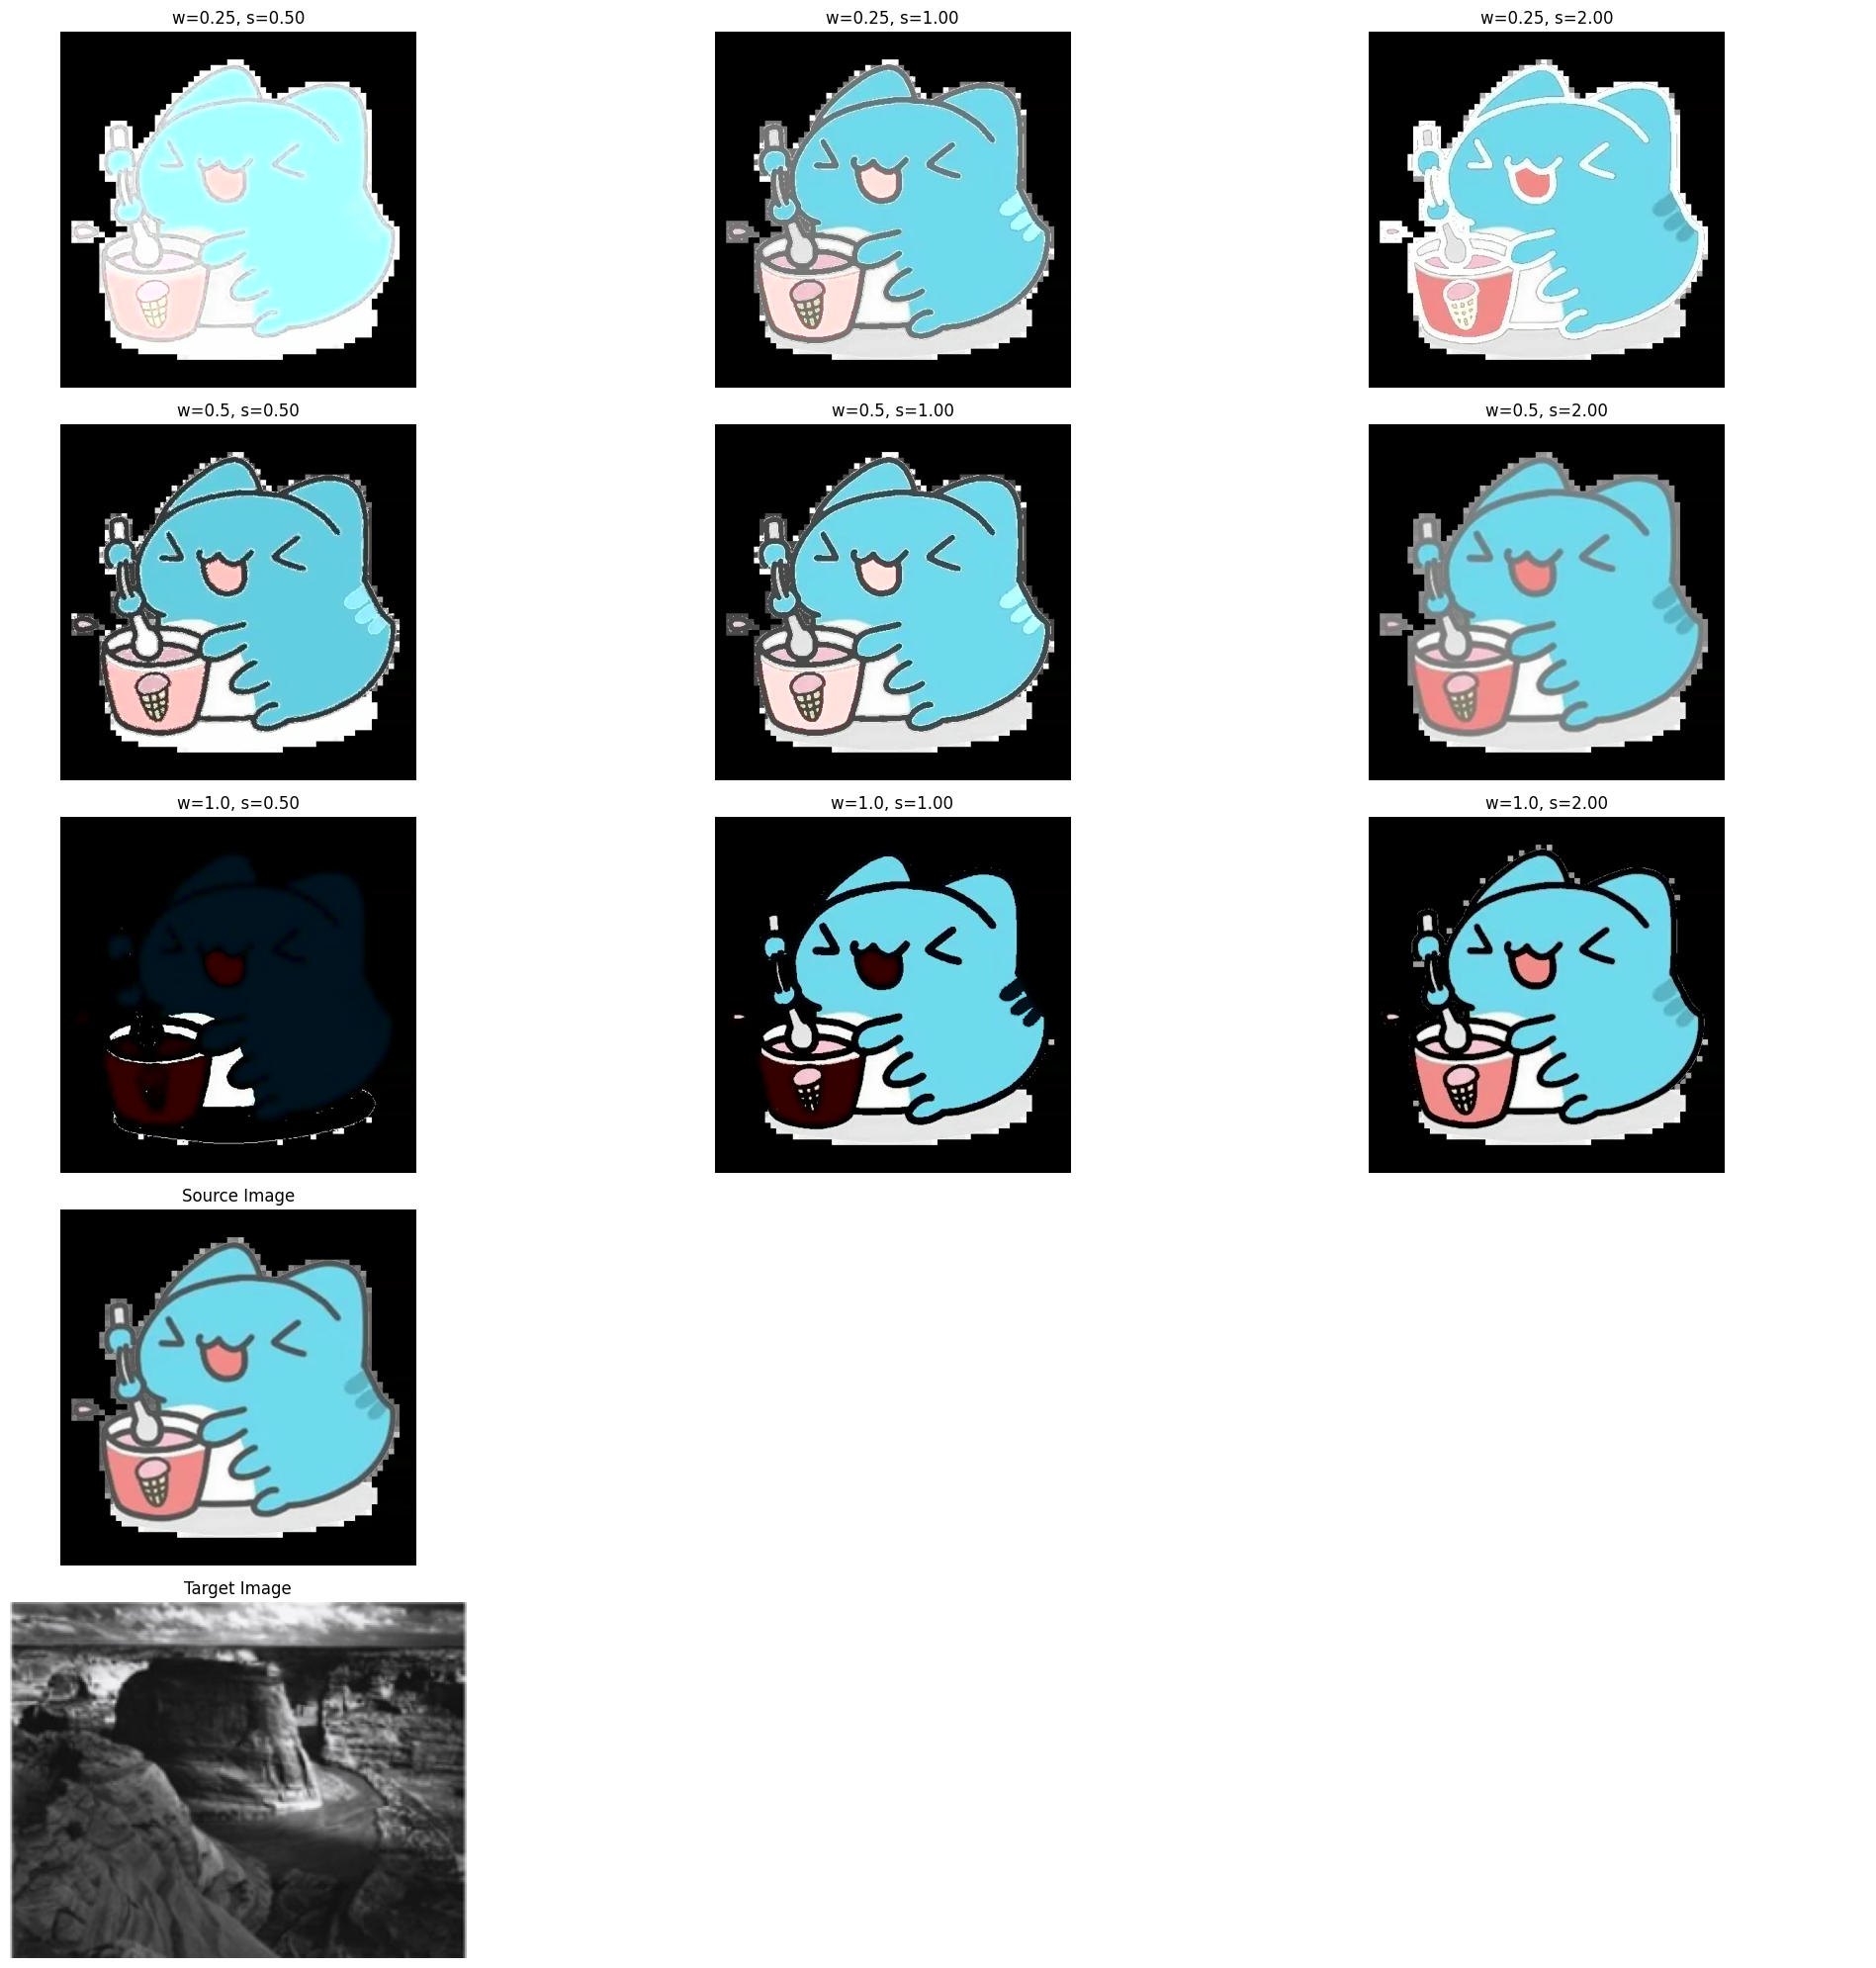

In [6]:
import cv2
import numpy as np
from skimage import color
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import math

# Convert image to CIELab color space
def rgb_to_lab(image):
    return color.rgb2lab(image)

# Convert image back to RGB color space
def lab_to_rgb(image):
    return color.lab2rgb(image)

# Compute histogram of an image channel
def compute_histogram(channel, num_bins=256):
    hist, bins = np.histogram(channel.flatten(), num_bins, [0, 256])
    return hist, bins

# Smooth histogram using Gaussian filter
def smooth_histogram(hist, scale):
    return gaussian_filter1d(hist, scale)

# Detect local minima in a histogram
def detect_minima(hist):
    minima = (np.diff(np.sign(np.diff(hist))) > 0).nonzero()[0] + 1
    return minima

# Reshape histogram region to match target
def reshape_histogram_region(source_region, target_region, source_mean, source_std, target_mean, target_std, ws, wt):
    reshaped_region = ((source_region - ws * source_mean) * (wt * target_std / (ws * source_std)) + wt * target_mean)
    return reshaped_region

# Transfer color between images
def transfer_color(source_image, target_image, ws, s_scale):
    # Resize target image to match the source image size
    target_image = cv2.resize(target_image, (source_image.shape[1], source_image.shape[0]))

    # Convert images to Lab color space
    source_lab = rgb_to_lab(source_image)
    target_lab = rgb_to_lab(target_image)

    # Initialize result image in Lab color space
    result_lab = np.copy(source_lab)

    for channel in range(3):
        source_channel = source_lab[:, :, channel]
        target_channel = target_lab[:, :, channel]

        # Compute histograms for source and target channels
        source_hist, source_bins = compute_histogram(source_channel)
        target_hist, target_bins = compute_histogram(target_channel)

        # Detect local minima at multiple scales
        scales = [s_scale]
        for scale in scales:
            smoothed_source_hist = smooth_histogram(source_hist, scale)
            smoothed_target_hist = smooth_histogram(target_hist, scale)

            source_minima = detect_minima(smoothed_source_hist)
            target_minima = detect_minima(smoothed_target_hist)

            # Check if there are enough minima to proceed
            if len(source_minima) < 2 or len(target_minima) < 2:
                continue

            # Reshape source histogram regions to match target
            for i in range(min(len(source_minima), len(target_minima)) - 1):
                source_region_indices = (source_channel >= source_bins[source_minima[i]]) & (source_channel < source_bins[source_minima[i+1]])
                target_region_indices = (target_channel >= target_bins[target_minima[i]]) & (target_channel < target_bins[target_minima[i+1]])

                source_region = source_channel[source_region_indices]
                target_region = target_channel[target_region_indices]

                if len(source_region) == 0 or len(target_region) == 0:
                    continue

                # Compute means and standard deviations
                source_mean = np.mean(source_region)
                source_std = np.std(source_region)
                target_mean = np.mean(target_region)
                target_std = np.std(target_region)

                wt = 1 - ws
                reshaped_region = reshape_histogram_region(source_region, target_region, source_mean, source_std, target_mean, target_std, ws, wt)
                result_lab[source_region_indices, channel] = reshaped_region

    # Ensure the Lab values are in the correct range before conversion
    result_lab[:, :, 0] = np.clip(result_lab[:, :, 0], 0, 100)
    result_lab[:, :, 1] = np.clip(result_lab[:, :, 1], -128, 127)
    result_lab[:, :, 2] = np.clip(result_lab[:, :, 2], -128, 127)

    # Convert result back to RGB
    result_rgb = lab_to_rgb(result_lab)
    return result_rgb

# Load source and target images
source_image = cv2.imread('/content/112.png')
target_image = cv2.imread('/content/sss.png')

# Convert images to float format
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB) / 255.0
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB) / 255.0

# Define B and Bmin values for Smax calculation
B = np.max(source_image)
Bmin = np.min(source_image[np.nonzero(source_image)])  # Avoid zero value
Smax = 1/4 * math.log2(B / Bmin)

# Define w and s values
w_values = [0.25, 0.5, 1.0]
s_scales = [0.25, 0.5, 1.0]

# Create a figure to display results
fig, axs = plt.subplots(len(w_values) + 2, len(s_scales), figsize=(20, 20))

# Apply color transfer for each combination of w and s
for i, w in enumerate(w_values):
    for j, s in enumerate(s_scales):
        s_value = s * Smax
        result_image = transfer_color(source_image, target_image, w, s_value)

        # Plot the result
        ax = axs[i, j]
        ax.imshow(result_image)
        ax.set_title(f'w={w}, s={s_value:.2f}')
        ax.axis('off')

# Display source and target images at the bottom
axs[len(w_values), 0].imshow(source_image)
axs[len(w_values), 0].set_title('Source Image')
axs[len(w_values), 0].axis('off')

axs[len(w_values) + 1, 0].imshow(target_image)
axs[len(w_values) + 1, 0].set_title('Target Image')
axs[len(w_values) + 1, 0].axis('off')

# Hide empty subplots
for col in range(1, len(s_scales)):
    axs[len(w_values), col].axis('off')
    axs[len(w_values)+1, col].axis('off')

# Display the images
plt.tight_layout()
plt.show()


# Fig7

<ipython-input-3-9d696a028902>:17: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched[~mask] = exposure.match_histograms(source[~mask], target[~mask], multichannel=True)


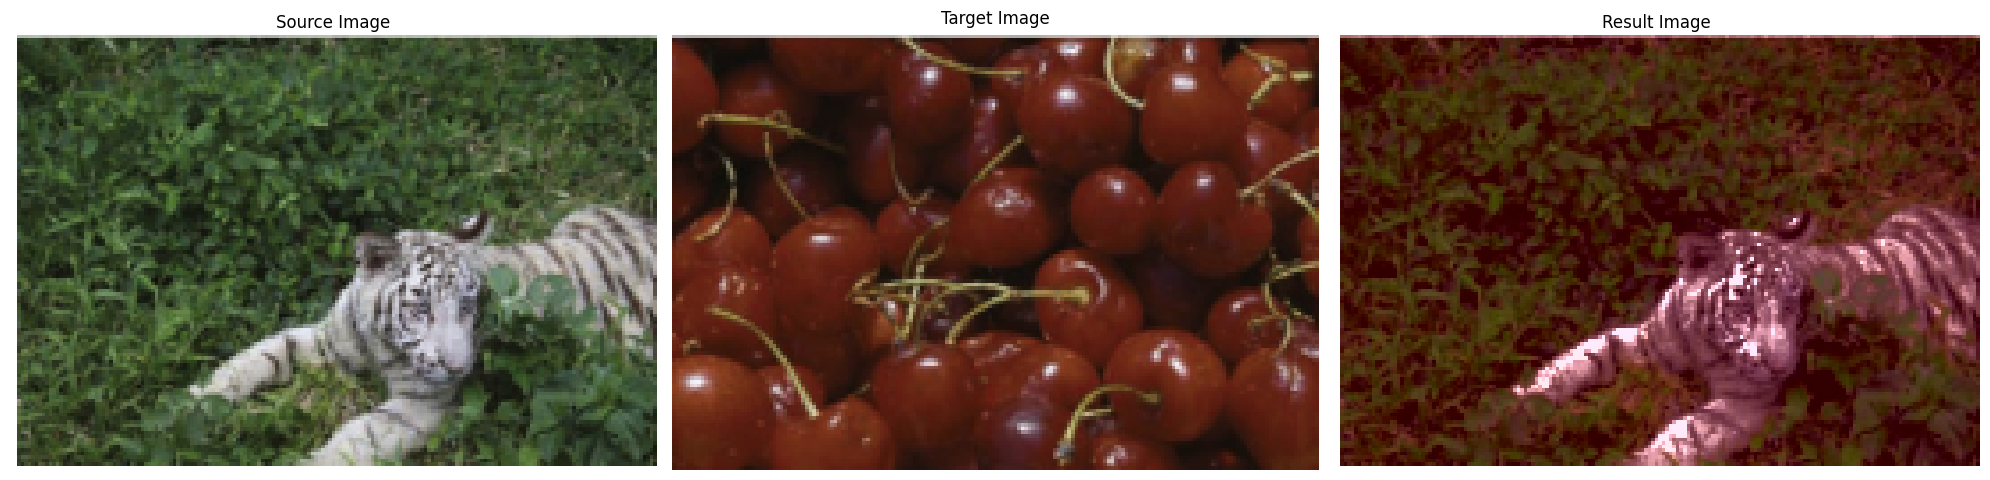

In [ ]:
import cv2
import numpy as np
from skimage import color, exposure
import matplotlib.pyplot as plt

# Convert image to CIELab color space
def rgb_to_lab(image):
    return color.rgb2lab(image)

# Convert image back to RGB color space
def lab_to_rgb(image):
    return color.lab2rgb(image)

# Match the histogram of source to target with anchoring
def match_histograms_with_anchoring(source, target, mask):
    matched = source.copy()
    matched[~mask] = exposure.match_histograms(source[~mask], target[~mask], multichannel=True)
    return matched

# Create a mask to detect white regions in the source image
def create_white_mask(image, threshold=0.95):
    gray_image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY) / 255.0
    mask = gray_image > threshold
    return mask

# Transfer color between images using histogram matching with anchoring
def transfer_color_histogram_matching(source_image, target_image, white_mask):
    # Resize target image to match the source image size
    target_image = cv2.resize(target_image, (source_image.shape[1], source_image.shape[0]))

    # Convert images to Lab color space
    source_lab = rgb_to_lab(source_image)
    target_lab = rgb_to_lab(target_image)

    # Perform histogram matching with anchoring
    matched_lab = match_histograms_with_anchoring(source_lab, target_lab, white_mask)

    # Convert matched image back to RGB
    result_rgb = lab_to_rgb(matched_lab)
    return result_rgb

# Load source and target images
source_image = cv2.imread('/content/tiger.png')
target_image = cv2.imread('/content/cherry.png')

# Convert images to float format
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB) / 255.0
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB) / 255.0

# Create white mask for source image
white_mask = create_white_mask(source_image)

# Apply color transfer using histogram matching with anchoring
result_image = transfer_color_histogram_matching(source_image, target_image, white_mask)

# Display the original and result images
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

axs[0].imshow(source_image)
axs[0].set_title('Source Image')
axs[0].axis('off')

axs[1].imshow(target_image)
axs[1].set_title('Target Image')
axs[1].axis('off')

axs[2].imshow(result_image)
axs[2].set_title('Result Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()


<ipython-input-4-67b41cb2cfd6>:16: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched = exposure.match_histograms(source, target, multichannel=True)


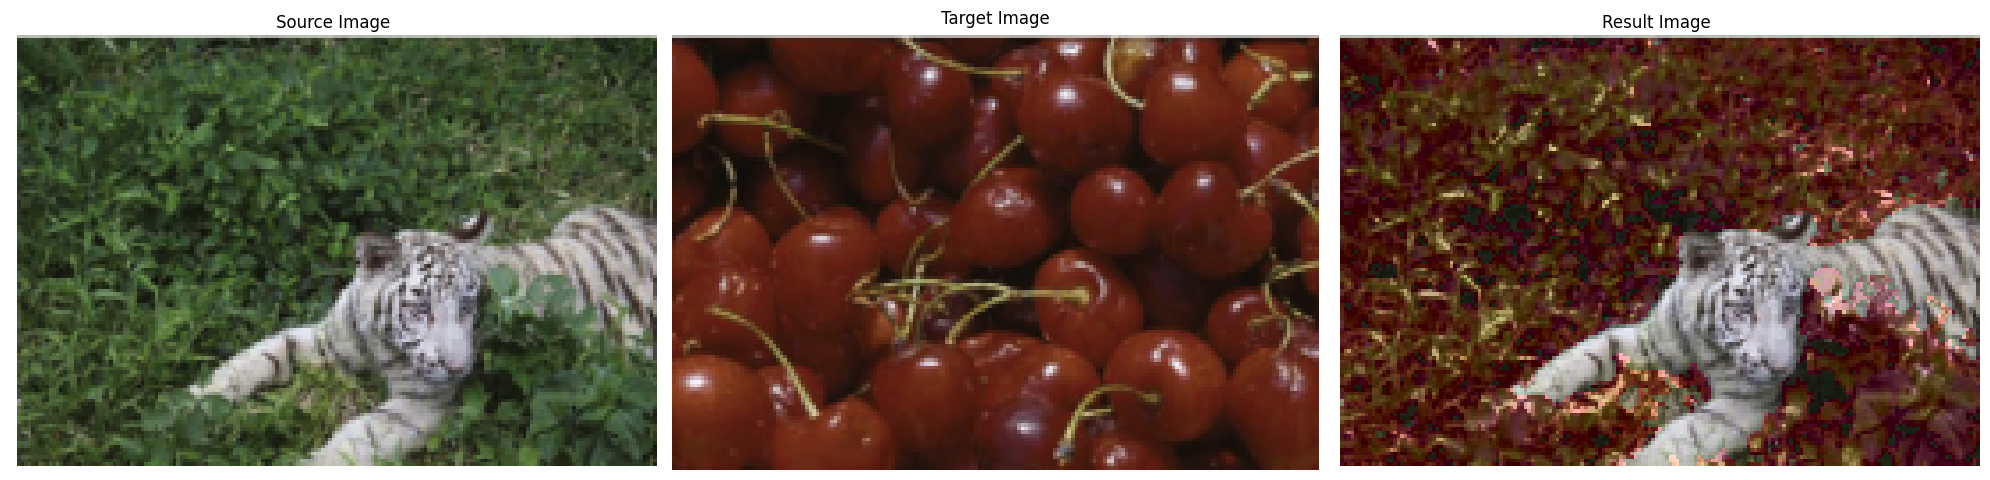

In [ ]:
import cv2
import numpy as np
from skimage import color, exposure
import matplotlib.pyplot as plt

# Convert image to CIELab color space
def rgb_to_lab(image):
    return color.rgb2lab(image)

# Convert image back to RGB color space
def lab_to_rgb(image):
    return color.lab2rgb(image)

# Match the histogram of source to target
def match_histograms(source, target):
    matched = exposure.match_histograms(source, target, multichannel=True)
    return matched

# Create a mask to detect green regions in the source image
def create_green_mask(image, lower_thresh=(35, 40, 40), upper_thresh=(85, 255, 255)):
    hsv_image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_image, lower_thresh, upper_thresh)
    return mask.astype(bool)

# Transfer color between images using histogram matching
def transfer_color_histogram_matching(source_image, target_image, green_mask):
    # Resize target image to match the source image size
    target_image = cv2.resize(target_image, (source_image.shape[1], source_image.shape[0]))

    # Convert images to Lab color space
    source_lab = rgb_to_lab(source_image)
    target_lab = rgb_to_lab(target_image)

    # Perform histogram matching only on green regions
    matched_lab = source_lab.copy()
    matched_lab[green_mask] = match_histograms(source_lab[green_mask], target_lab[green_mask])

    # Convert matched image back to RGB
    result_rgb = lab_to_rgb(matched_lab)
    return result_rgb

# Load source and target images
source_image = cv2.imread('/content/tiger.png')
target_image = cv2.imread('/content/cherry.png')

# Convert images to float format
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB) / 255.0
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB) / 255.0

# Create green mask for source image
green_mask = create_green_mask(source_image)

# Apply color transfer using histogram matching
result_image = transfer_color_histogram_matching(source_image, target_image, green_mask)

# Display the original and result images
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

axs[0].imshow(source_image)
axs[0].set_title('Source Image')
axs[0].axis('off')

axs[1].imshow(target_image)
axs[1].set_title('Target Image')
axs[1].axis('off')

axs[2].imshow(result_image)
axs[2].set_title('Result Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()


# Fig9

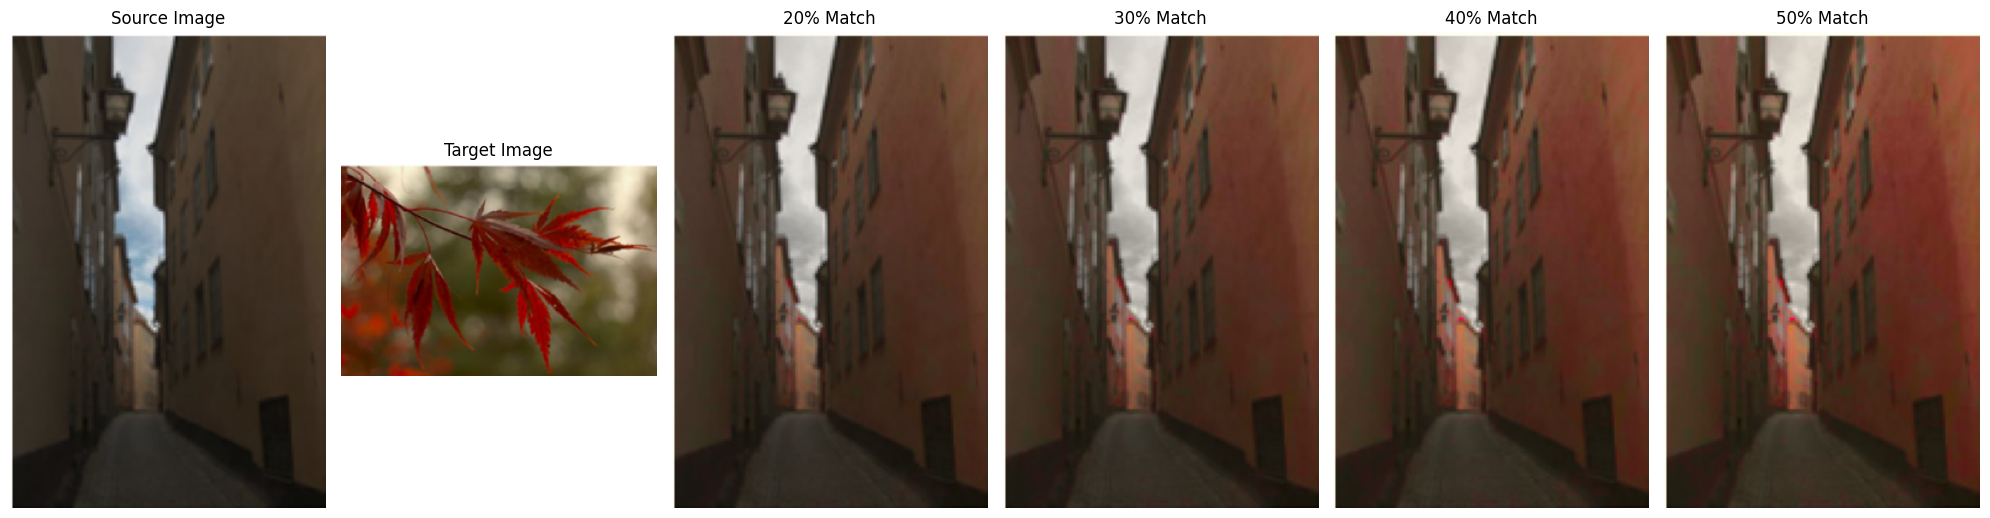

In [66]:
import cv2
import numpy as np
from skimage import color
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import math

# Convert image to CIELab color space
def rgb_to_lab(image):
    return color.rgb2lab(image)

# Convert image back to RGB color space
def lab_to_rgb(image):
    return color.lab2rgb(image)

# Compute histogram of an image channel
def compute_histogram(channel, num_bins=256):
    hist, bins = np.histogram(channel.flatten(), num_bins, [0, 256])
    return hist, bins

# Smooth histogram using Gaussian filter
def smooth_histogram(hist, scale):
    return gaussian_filter1d(hist, scale)

# Match histogram of the source to the target
def match_histograms(source, target, match_percent):
    source_hist, source_bins = compute_histogram(source)
    target_hist, target_bins = compute_histogram(target)

    # Compute the cumulative distribution function for both histograms
    source_cdf = np.cumsum(source_hist).astype(float)
    source_cdf /= source_cdf[-1]

    target_cdf = np.cumsum(target_hist).astype(float)
    target_cdf /= target_cdf[-1]

    # Create a lookup table to map source pixel values to target pixel values
    lookup_table = np.interp(source_cdf, target_cdf, target_bins[:-1])

    # Apply match_percent to control the degree of matching
    lookup_table = source_bins[:-1] * (1 - match_percent) + lookup_table * match_percent

    # Map the source image through the lookup table
    matched_source = np.interp(source.flatten(), source_bins[:-1], lookup_table)
    return matched_source.reshape(source.shape)

# Apply color transfer from target to source image
def transfer_color(source_image, target_image, match_percent):
    # Resize target image to match the source image size
    target_image = cv2.resize(target_image, (source_image.shape[1], source_image.shape[0]))

    # Convert images to Lab color space
    source_lab = rgb_to_lab(source_image)
    target_lab = rgb_to_lab(target_image)

    # Initialize result image in Lab color space
    result_lab = np.copy(source_lab)

    for channel in range(3):
        source_channel = source_lab[:, :, channel]
        target_channel = target_lab[:, :, channel]

        # Match histograms of the source to the target
        matched_source_channel = match_histograms(source_channel, target_channel, match_percent)
        result_lab[:, :, channel] = matched_source_channel

    # Ensure the Lab values are in the correct range before conversion
    result_lab[:, :, 0] = np.clip(result_lab[:, :, 0], 0, 100)
    result_lab[:, :, 1] = np.clip(result_lab[:, :, 1], -128, 127)
    result_lab[:, :, 2] = np.clip(result_lab[:, :, 2], -128, 127)

    # Convert result back to RGB
    result_rgb = lab_to_rgb(result_lab)

    return result_rgb

# Load source and target images
source_image = cv2.imread('/content/996.png')
target_image = cv2.imread('/content/55688.png')

# Convert images to float format
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB) / 255.0
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB) / 255.0

# Define match percentages
match_percentages = [0.2, 0.3, 0.4, 0.5]

# Create a figure to display results
fig, axs = plt.subplots(1, len(match_percentages) + 2, figsize=(20, 20))

# Display source and target images
axs[0].imshow(source_image)
axs[0].set_title('Source Image')
axs[0].axis('off')

axs[1].imshow(target_image)
axs[1].set_title('Target Image')
axs[1].axis('off')

# Apply color transfer for each match percentage and display the results
for i, match_percent in enumerate(match_percentages):
    result_image = transfer_color(source_image, target_image, match_percent)
    axs[i + 2].imshow(result_image)
    axs[i + 2].set_title(f'{int(match_percent * 100)}% Match')
    axs[i + 2].axis('off')

# Display the images
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)


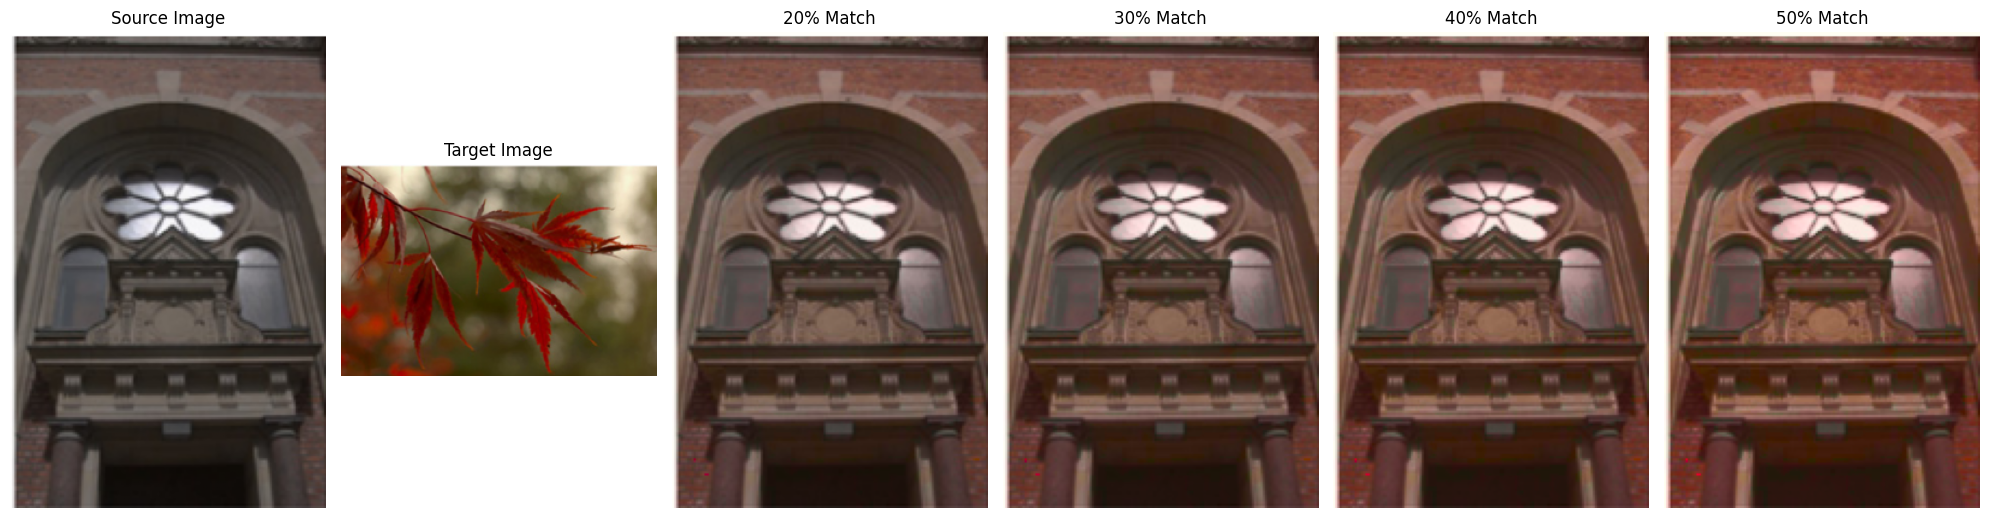

In [7]:
import cv2
import numpy as np
from skimage import color
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import math

# Convert image to CIELab color space
def rgb_to_lab(image):
    return color.rgb2lab(image)

# Convert image back to RGB color space
def lab_to_rgb(image):
    return color.lab2rgb(image)

# Compute histogram of an image channel
def compute_histogram(channel, num_bins=256):
    hist, bins = np.histogram(channel.flatten(), num_bins, [0, 256])
    return hist, bins

# Smooth histogram using Gaussian filter
def smooth_histogram(hist, scale):
    return gaussian_filter1d(hist, scale)

# Match histogram of the source to the target
def match_histograms(source, target, match_percent):
    source_hist, source_bins = compute_histogram(source)
    target_hist, target_bins = compute_histogram(target)

    # Compute the cumulative distribution function for both histograms
    source_cdf = np.cumsum(source_hist).astype(float)
    source_cdf /= source_cdf[-1]

    target_cdf = np.cumsum(target_hist).astype(float)
    target_cdf /= target_cdf[-1]

    # Create a lookup table to map source pixel values to target pixel values
    lookup_table = np.interp(source_cdf, target_cdf, target_bins[:-1])

    # Apply match_percent to control the degree of matching
    lookup_table = source_bins[:-1] * (1 - match_percent) + lookup_table * match_percent

    # Map the source image through the lookup table
    matched_source = np.interp(source.flatten(), source_bins[:-1], lookup_table)
    return matched_source.reshape(source.shape)

# Apply color transfer from target to source image
def transfer_color(source_image, target_image, match_percent):
    # Resize target image to match the source image size
    target_image = cv2.resize(target_image, (source_image.shape[1], source_image.shape[0]))

    # Convert images to Lab color space
    source_lab = rgb_to_lab(source_image)
    target_lab = rgb_to_lab(target_image)

    # Initialize result image in Lab color space
    result_lab = np.copy(source_lab)

    for channel in range(3):
        source_channel = source_lab[:, :, channel]
        target_channel = target_lab[:, :, channel]

        # Match histograms of the source to the target
        matched_source_channel = match_histograms(source_channel, target_channel, match_percent)
        result_lab[:, :, channel] = matched_source_channel

    # Ensure the Lab values are in the correct range before conversion
    result_lab[:, :, 0] = np.clip(result_lab[:, :, 0], 0, 100)
    result_lab[:, :, 1] = np.clip(result_lab[:, :, 1], -128, 127)
    result_lab[:, :, 2] = np.clip(result_lab[:, :, 2], -128, 127)

    # Convert result back to RGB
    result_rgb = lab_to_rgb(result_lab)

    return result_rgb

# Load source and target images
source_image = cv2.imread('/content/sssaw.png')
target_image = cv2.imread('/content/55688.png')

# Convert images to float format
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB) / 255.0
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB) / 255.0

# Define match percentages
match_percentages = [0.2, 0.3, 0.4, 0.5]

# Create a figure to display results
fig, axs = plt.subplots(1, len(match_percentages) + 2, figsize=(20, 20))

# Display source and target images
axs[0].imshow(source_image)
axs[0].set_title('Source Image')
axs[0].axis('off')

axs[1].imshow(target_image)
axs[1].set_title('Target Image')
axs[1].axis('off')

# Apply color transfer for each match percentage and display the results
for i, match_percent in enumerate(match_percentages):
    result_image = transfer_color(source_image, target_image, match_percent)
    axs[i + 2].imshow(result_image)
    axs[i + 2].set_title(f'{int(match_percent * 100)}% Match')
    axs[i + 2].axis('off')

# Display the images
plt.tight_layout()
plt.show()


# Fig 10

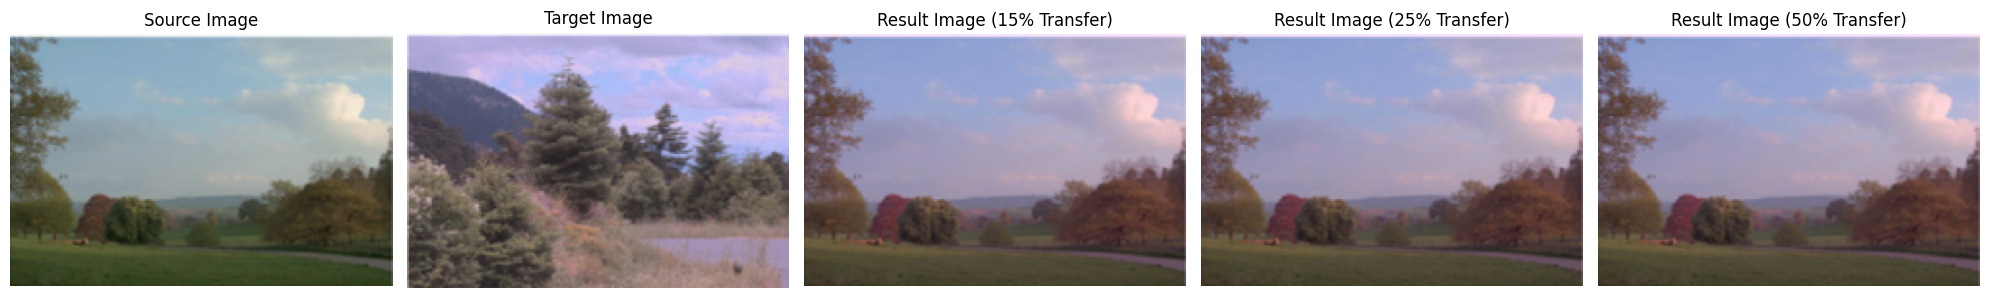

In [74]:
import cv2
import numpy as np
from skimage import color
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# Convert image to CIELab color space
def rgb_to_lab(image):
    return color.rgb2lab(image)

# Convert image back to RGB color space
def lab_to_rgb(image):
    return color.lab2rgb(image)

# Compute histogram of an image channel
def compute_histogram(channel, num_bins=256):
    hist, bins = np.histogram(channel.flatten(), num_bins, [0, 256])
    return hist, bins

# Smooth histogram using Gaussian filter
def smooth_histogram(hist, scale):
    return gaussian_filter1d(hist, scale)

# Match histogram of the source to the target
def match_histograms(source, target):
    source_hist, source_bins = compute_histogram(source)
    target_hist, target_bins = compute_histogram(target)

    # Compute the cumulative distribution function for both histograms
    source_cdf = np.cumsum(source_hist).astype(float)
    source_cdf /= source_cdf[-1]

    target_cdf = np.cumsum(target_hist).astype(float)
    target_cdf /= target_cdf[-1]

    # Create a lookup table to map source pixel values to target pixel values
    lookup_table = np.interp(source_cdf, target_cdf, target_bins[:-1])

    # Map the source image through the lookup table
    matched_source = np.interp(source.flatten(), source_bins[:-1], lookup_table)
    return matched_source.reshape(source.shape)

# Apply color transfer from target to source image with a given percentage
def transfer_color(source_image, target_image, transfer_percentage):
    # Resize target image to match the source image size
    target_image = cv2.resize(target_image, (source_image.shape[1], source_image.shape[0]))

    # Convert images to Lab color space
    source_lab = rgb_to_lab(source_image)
    target_lab = rgb_to_lab(target_image)

    # Initialize result image in Lab color space
    result_lab = np.copy(source_lab)

    # Calculate mean and standard deviation of target image in Lab space
    target_mean = np.mean(target_lab, axis=(0, 1))
    target_std = np.std(target_lab, axis=(0, 1))

    # Adjust the color of each channel in the source image
    for channel in range(3):
        source_channel = source_lab[:, :, channel]
        source_mean = np.mean(source_channel)
        source_std = np.std(source_channel)

        # Scale the source channel to match target statistics
        result_lab[:, :, channel] = (source_channel - source_mean) * (target_std[channel] / source_std) + target_mean[channel]

    # Ensure the Lab values are in the correct range before conversion
    result_lab[:, :, 0] = np.clip(result_lab[:, :, 0], 0, 100)
    result_lab[:, :, 1] = np.clip(result_lab[:, :, 1], -128, 127)
    result_lab[:, :, 2] = np.clip(result_lab[:, :, 2], -128, 127)

    # Convert result back to RGB
    result_rgb = lab_to_rgb(result_lab)

    return result_rgb

# Load source and target images
source_image = cv2.imread('/content/sun1.png')
target_image = cv2.imread('/content/pur.png')

# Convert images to float format
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB) / 255.0
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB) / 255.0

# Define the transfer percentages
transfer_percentages = [0.15, 0.25, 0.5]

# Apply color transfer for each percentage
result_images = []
for idx, percentage in enumerate(transfer_percentages):
    result_image = transfer_color(source_image, target_image, percentage)
    result_images.append(result_image)

# Display the images
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
axs[0].imshow(source_image)
axs[0].set_title('Source Image')
axs[0].axis('off')

axs[1].imshow(target_image)
axs[1].set_title('Target Image')
axs[1].axis('off')

for i in range(len(result_images)):
    axs[i + 2].imshow(result_images[i])
    axs[i + 2].set_title(f'Result Image ({int(transfer_percentages[i] * 100)}% Transfer)')
    axs[i + 2].axis('off')

plt.tight_layout()
plt.show()


# Fig14-16 自行輸入ratio

Please input ratio (0 to 1): 1


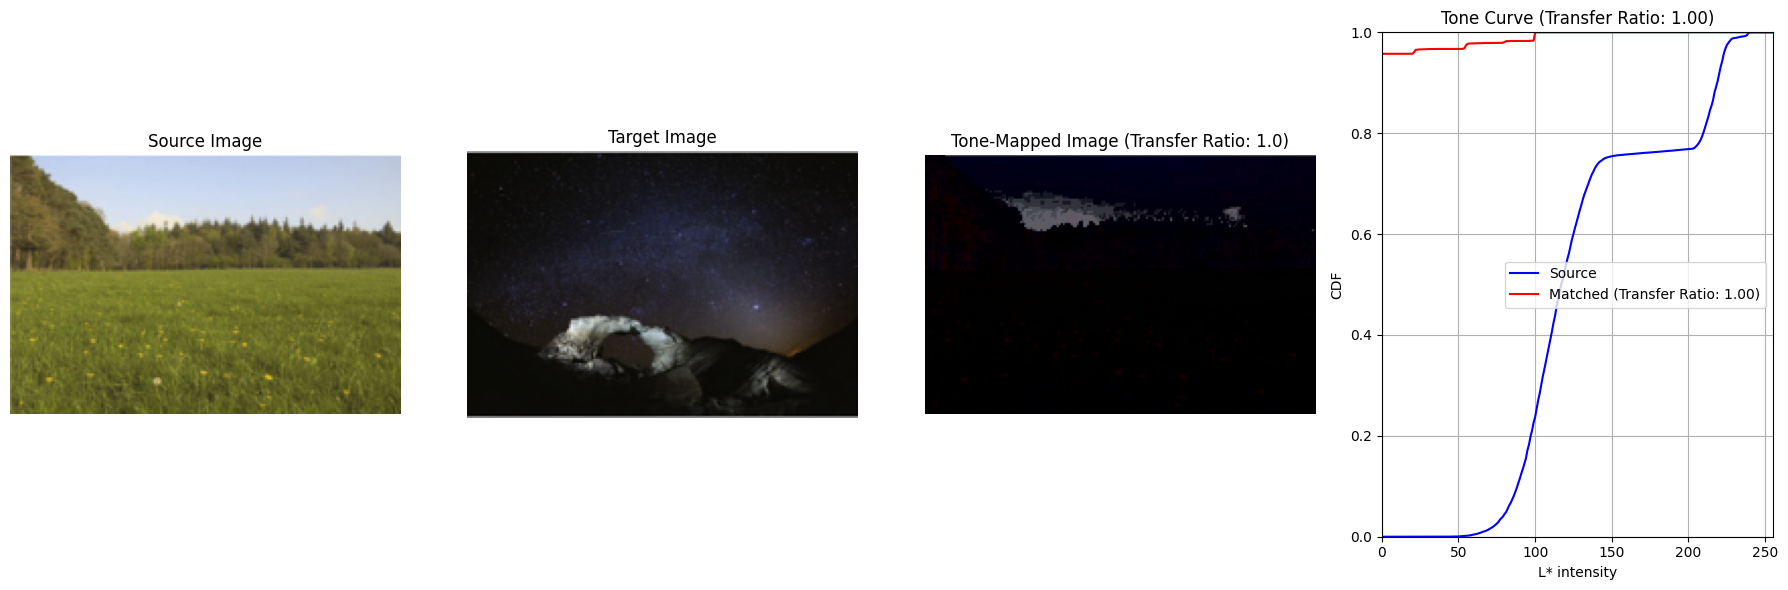

In [134]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the source and target images (replace with your own paths)
source_path = '/content/53.png'
target_path = '/content/52.png'

source = cv2.imread(source_path)
target = cv2.imread(target_path)

# Convert images from BGR to RGB
source_rgb = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
target_rgb = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

# Convert images to Lab color space
source_lab = cv2.cvtColor(source_rgb, cv2.COLOR_RGB2Lab)
target_lab = cv2.cvtColor(target_rgb, cv2.COLOR_RGB2Lab)

# Function to match histograms of source to target
def match_histograms(source, target, transfer_ratio):
    matched = np.zeros_like(source)
    for i in range(3):  # Apply histogram matching for each channel (L*, a*, b*)
        source_hist, _ = np.histogram(source[:, :, i].flatten(), bins=256, range=[0, 256])
        target_hist, _ = np.histogram(target[:, :, i].flatten(), bins=256, range=[0, 256])

        # Compute cumulative distribution functions (CDF)
        source_cdf = source_hist.cumsum()
        source_cdf_normalized = source_cdf / float(source_cdf[-1])  # Normalize CDF
        target_cdf = target_hist.cumsum()
        target_cdf_normalized = target_cdf / float(target_cdf[-1])  # Normalize CDF

        # Compute the mapping from source to target with transfer_ratio
        mapping = np.zeros(256, dtype=np.uint8)
        for j in range(256):
            if transfer_ratio == 0:
                mapping[j] = j  # No transfer, keep original source
            elif transfer_ratio == 1:
                mapping[j] = np.argmin(np.abs(source_cdf_normalized[j] - target_cdf_normalized))
            else:
                # Linear combination of source and target histograms
                mapping[j] = np.clip((1 - transfer_ratio) * j + transfer_ratio * np.argmin(np.abs(source_cdf_normalized[j] - target_cdf_normalized)), 0, 255)

        # Apply the mapping to the source channel
        matched[:, :, i] = mapping[source[:, :, i]]

    return matched

# Function to adjust local contrast
def adjust_local_contrast(source_lab, matched_lab):
    # Extract the L* channel
    src_L = source_lab[:, :, 0].astype('float32')
    matched_L = matched_lab[:, :, 0].astype('float32')

    # Compute the detail layer
    detail_layer = src_L - cv2.GaussianBlur(src_L, (3, 3), 3)

    # Modify the detail layer
    modified_detail_layer = detail_layer + (matched_L - src_L)

    # Combine modified detail layer with the matched L* channel
    combined_L = matched_L + modified_detail_layer

    # Clip values to valid range
    combined_L = np.clip(combined_L, 0, 100)

    # Replace the L* channel in the matched Lab image
    matched_lab[:, :, 0] = combined_L.astype('uint8')

    return matched_lab

# Function to plot tone curve
def plot_tone_curve(ax, source_lab, matched_lab, transfer_ratio):
    # Extract L* channel from source and matched Lab images
    src_L = source_lab[:, :, 0].flatten()
    matched_L = matched_lab[:, :, 0].flatten()

    # Compute histograms of L* channel
    src_hist, _ = np.histogram(src_L, bins=256, range=[0, 256])
    matched_hist, _ = np.histogram(matched_L, bins=256, range=[0, 256])

    # Compute cumulative distribution functions (CDF)
    src_cdf = src_hist.cumsum()
    src_cdf_normalized = src_cdf / float(src_cdf[-1])
    matched_cdf = matched_hist.cumsum()
    matched_cdf_normalized = matched_cdf / float(matched_cdf[-1])

    # Plot tone curve
    ax.plot(np.arange(256), src_cdf_normalized, color='b', label='Source')
    ax.plot(np.arange(256), matched_cdf_normalized, color='r', label='Matched (Transfer Ratio: {:.2f})'.format(transfer_ratio))
    ax.set_title('Tone Curve (Transfer Ratio: {:.2f})'.format(transfer_ratio))
    ax.set_xlabel('L* intensity')
    ax.set_ylabel('CDF')
    ax.legend()
    ax.grid(True)
    ax.set_xlim([0, 255])
    ax.set_ylim([0, 1])

# Perform histogram matching with the specified transfer_ratio
transfer_ratio = float(input("Please input ratio (0 to 1): "))
matched_lab = match_histograms(source_lab, target_lab, transfer_ratio)

# Adjust local contrast
final_lab = adjust_local_contrast(source_lab, matched_lab)

# Convert back to RGB color space
final_rgb = cv2.cvtColor(final_lab, cv2.COLOR_Lab2RGB)

# Display the original source, target, final tone-mapped image, and tone curve
plt.figure(figsize=(18, 6))
plt.subplot(1, 4, 1)
plt.title('Source Image')
plt.imshow(source_rgb)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Target Image')
plt.imshow(target_rgb)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Tone-Mapped Image (Transfer Ratio: {})'.format(transfer_ratio))
plt.imshow(final_rgb)
plt.axis('off')

plt.subplot(1, 4, 4)
plot_tone_curve(plt.gca(), source_lab, matched_lab, transfer_ratio)

plt.tight_layout()
plt.show()



# 額外實作

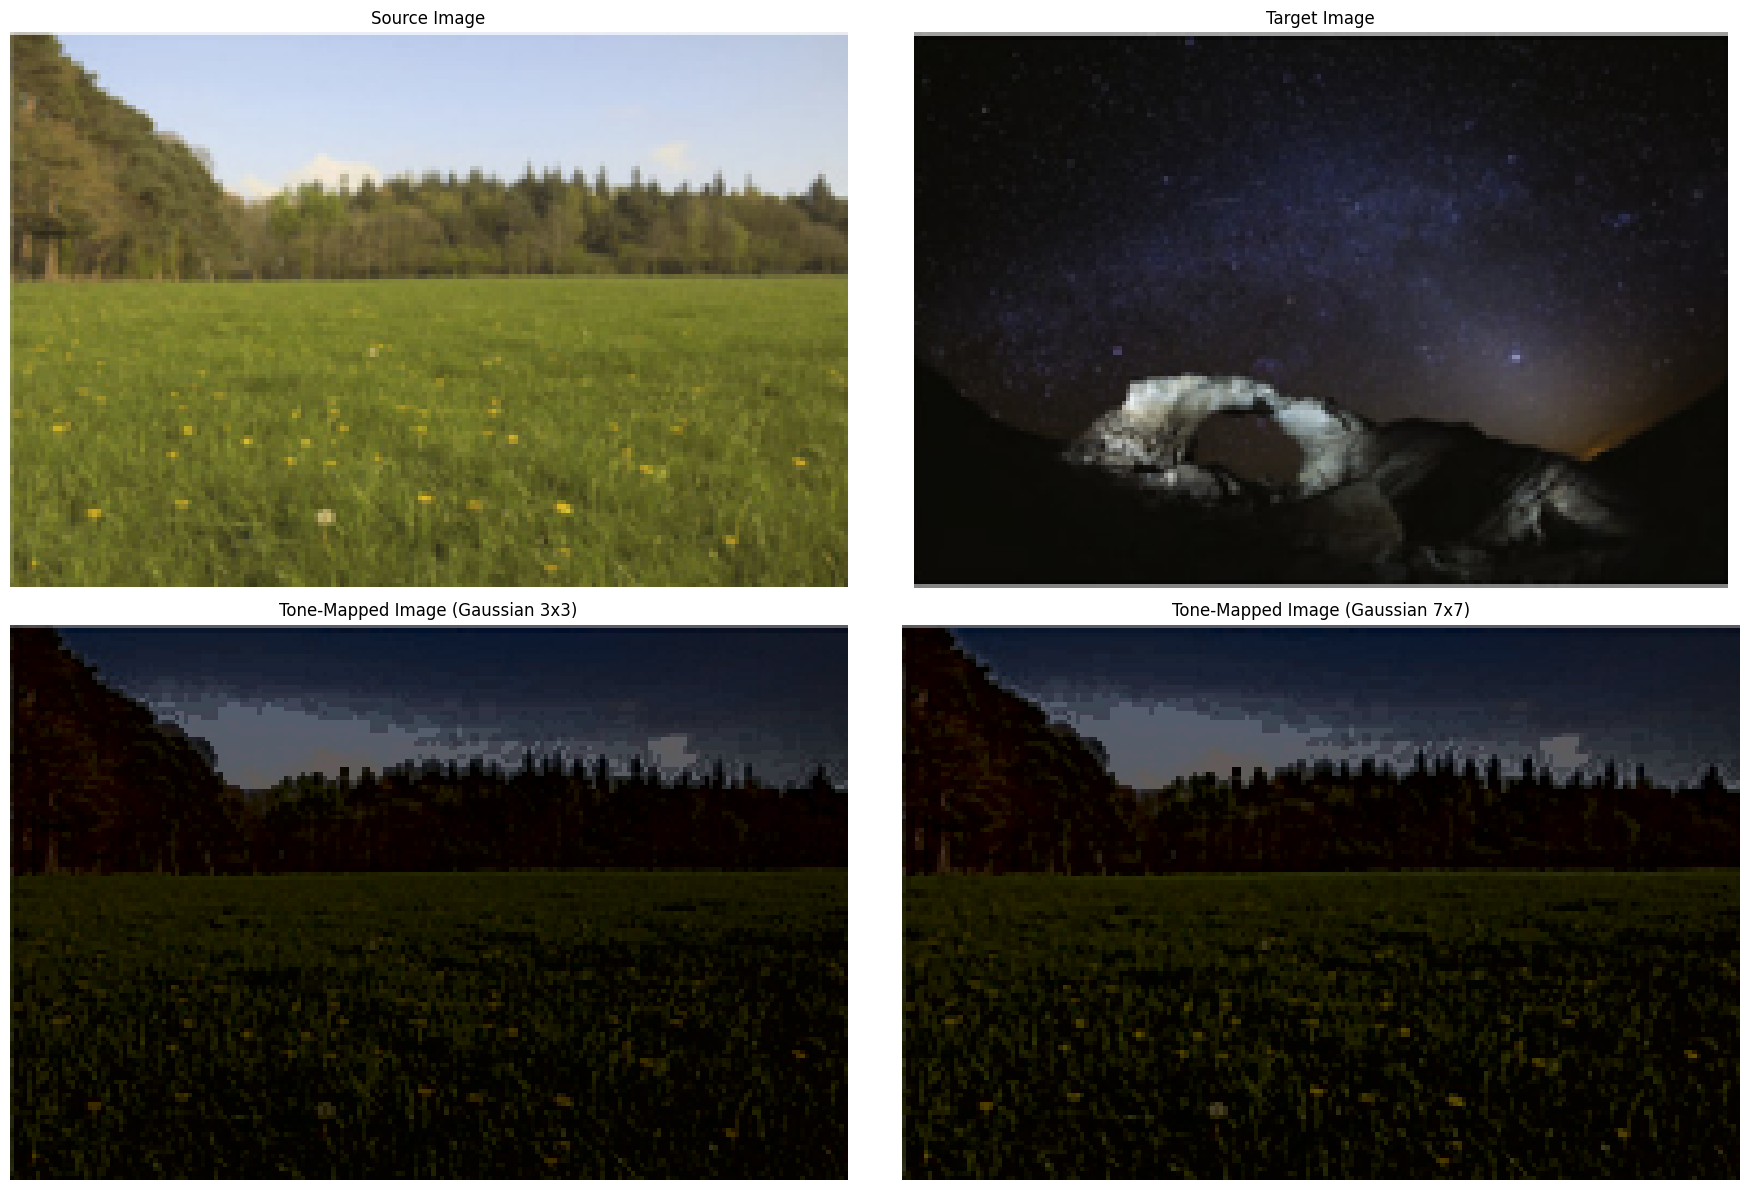

In [121]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the source and target images (replace with your own paths)
source_path = '/content/53.png'
target_path = '/content/52.png'

source = cv2.imread(source_path)
target = cv2.imread(target_path)

# Convert images from BGR to RGB
source_rgb = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
target_rgb = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

# Convert images to Lab color space
source_lab = cv2.cvtColor(source_rgb, cv2.COLOR_RGB2Lab)
target_lab = cv2.cvtColor(target_rgb, cv2.COLOR_RGB2Lab)

# Function to match histograms of source to target
def match_histograms(source, target, transfer_ratio):
    matched = np.zeros_like(source)
    for i in range(3):  # Apply histogram matching for each channel (L*, a*, b*)
        source_hist, _ = np.histogram(source[:, :, i].flatten(), bins=256, range=[0, 256])
        target_hist, _ = np.histogram(target[:, :, i].flatten(), bins=256, range=[0, 256])

        # Compute cumulative distribution functions (CDF)
        source_cdf = source_hist.cumsum()
        source_cdf_normalized = source_cdf / float(source_cdf[-1])  # Normalize CDF
        target_cdf = target_hist.cumsum()
        target_cdf_normalized = target_cdf / float(target_cdf[-1])  # Normalize CDF

        # Compute the mapping from source to target with transfer_ratio
        mapping = np.zeros(256, dtype=np.uint8)
        for j in range(256):
            if transfer_ratio == 0:
                mapping[j] = j  # No transfer, keep original source
            elif transfer_ratio == 1:
                mapping[j] = np.argmin(np.abs(source_cdf_normalized[j] - target_cdf_normalized))
            else:
                # Linear combination of source and target histograms
                mapping[j] = np.clip((1 - transfer_ratio) * j + transfer_ratio * np.argmin(np.abs(source_cdf_normalized[j] - target_cdf_normalized)), 0, 255)

        # Apply the mapping to the source channel
        matched[:, :, i] = mapping[source[:, :, i]]

    return matched

# Function to adjust local contrast
def adjust_local_contrast(source_lab, matched_lab, gaussian_kernel):
    # Extract the L* channel
    src_L = source_lab[:, :, 0].astype('float32')
    matched_L = matched_lab[:, :, 0].astype('float32')

    # Compute the detail layer
    detail_layer = src_L - cv2.GaussianBlur(src_L, gaussian_kernel, 0)

    # Modify the detail layer
    modified_detail_layer = detail_layer + (matched_L - src_L)

    # Combine modified detail layer with the matched L* channel
    combined_L = matched_L + modified_detail_layer

    # Clip values to valid range
    combined_L = np.clip(combined_L, 0, 100)

    # Replace the L* channel in the matched Lab image
    matched_lab[:, :, 0] = combined_L.astype('uint8')

    return matched_lab

# Perform histogram matching with the specified transfer_ratio

transfer_ratio = 0.55

# Match histograms with Gaussian blur kernel (3, 3)
matched_lab_3 = match_histograms(source_lab, target_lab, transfer_ratio)
final_lab_3 = adjust_local_contrast(source_lab, matched_lab_3, (3, 3))
final_rgb_3 = cv2.cvtColor(final_lab_3, cv2.COLOR_Lab2RGB)

# Match histograms with Gaussian blur kernel (7, 7)
matched_lab_5 = match_histograms(source_lab, target_lab, transfer_ratio)
final_lab_5 = adjust_local_contrast(source_lab, matched_lab_5, (7, 7))
final_rgb_5 = cv2.cvtColor(final_lab_5, cv2.COLOR_Lab2RGB)

# Display the results side by side
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.title('Source Image')
plt.imshow(source_rgb)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Target Image')
plt.imshow(target_rgb)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Tone-Mapped Image (Gaussian 3x3)')
plt.imshow(final_rgb_3)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Tone-Mapped Image (Gaussian 7x7)')
plt.imshow(final_rgb_5)
plt.axis('off')

plt.tight_layout()
plt.show()


Please input ratio (0 to 1): 0.55


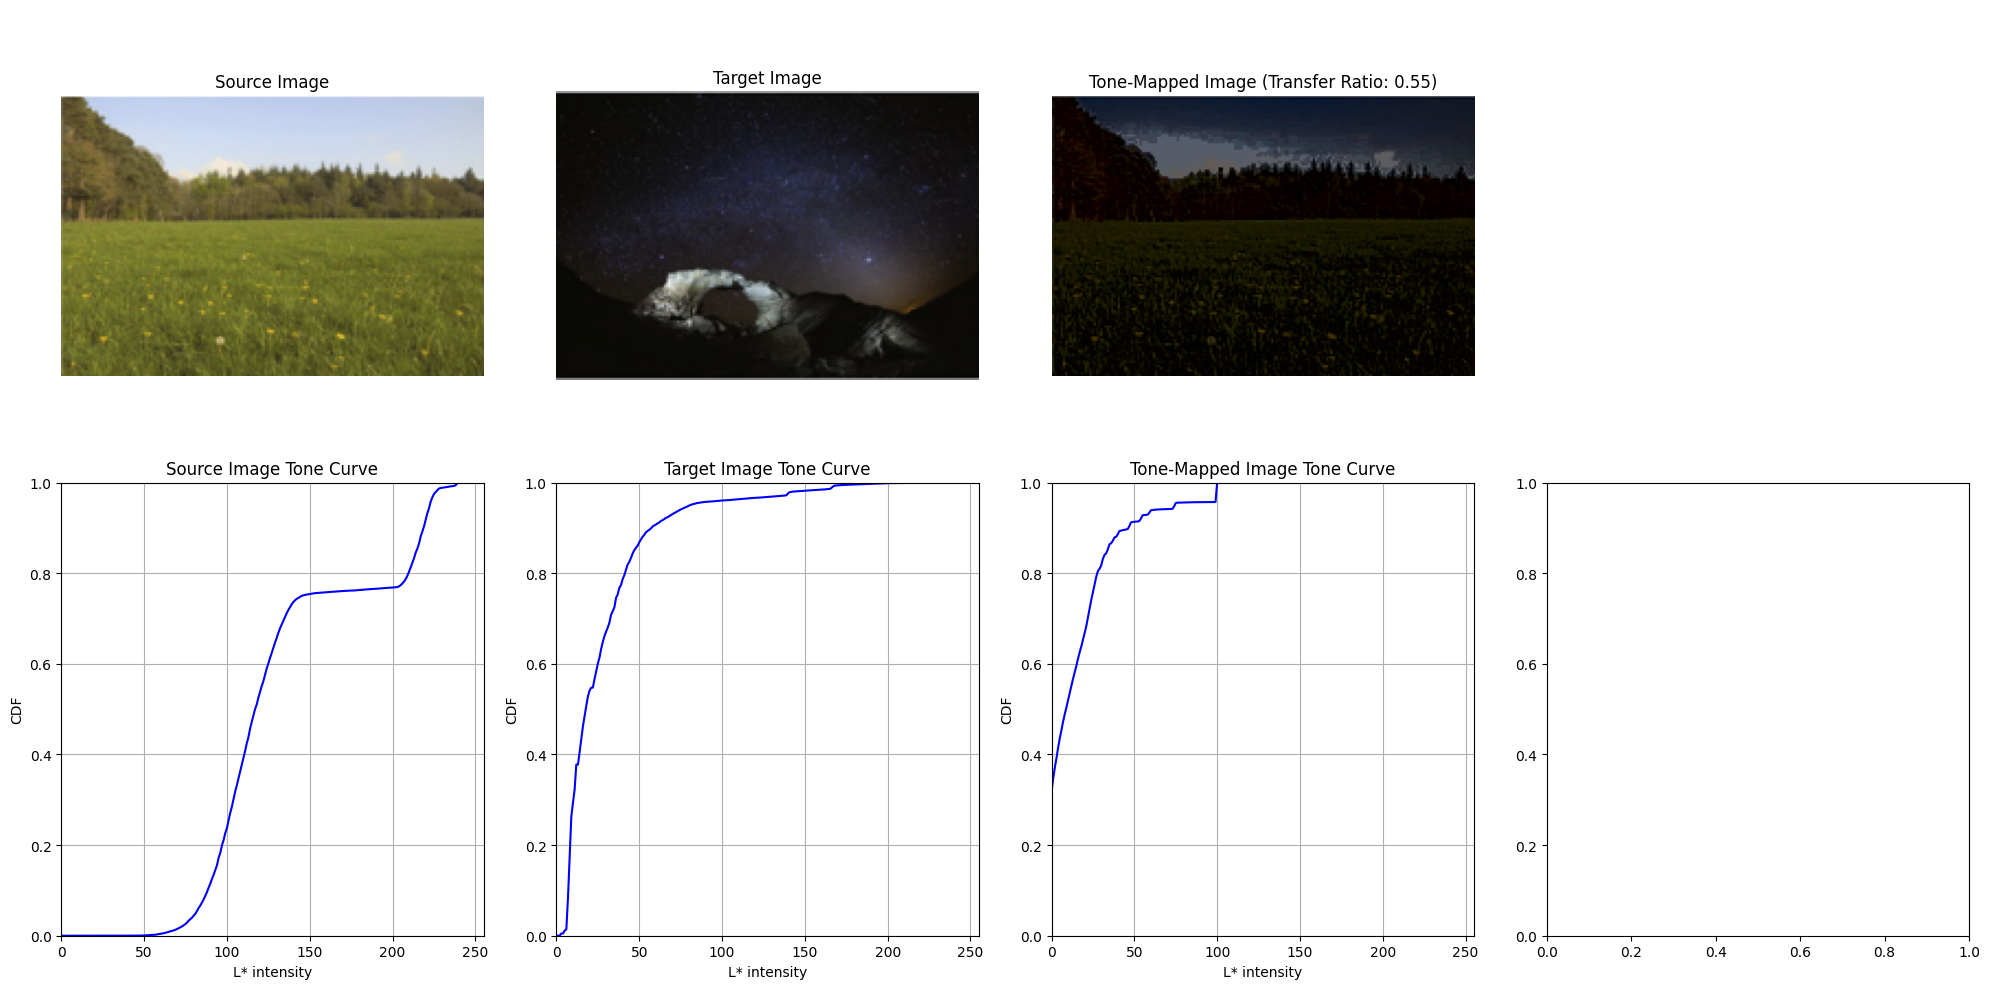

In [117]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the source and target images (replace with your own paths)
source_path = '/content/53.png'
target_path = '/content/52.png'

source = cv2.imread(source_path)
target = cv2.imread(target_path)

# Convert images from BGR to RGB
source_rgb = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
target_rgb = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

# Convert images to Lab color space
source_lab = cv2.cvtColor(source_rgb, cv2.COLOR_RGB2Lab)
target_lab = cv2.cvtColor(target_rgb, cv2.COLOR_RGB2Lab)

# Function to match histograms of source to target
def match_histograms(source, target, transfer_ratio):
    matched = np.zeros_like(source)
    for i in range(3):  # Apply histogram matching for each channel (L*, a*, b*)
        source_hist, _ = np.histogram(source[:, :, i].flatten(), bins=256, range=[0, 256])
        target_hist, _ = np.histogram(target[:, :, i].flatten(), bins=256, range=[0, 256])

        # Compute cumulative distribution functions (CDF)
        source_cdf = source_hist.cumsum()
        source_cdf_normalized = source_cdf / float(source_cdf[-1])  # Normalize CDF
        target_cdf = target_hist.cumsum()
        target_cdf_normalized = target_cdf / float(target_cdf[-1])  # Normalize CDF

        # Compute the mapping from source to target with transfer_ratio
        mapping = np.zeros(256, dtype=np.uint8)
        for j in range(256):
            if transfer_ratio == 0:
                mapping[j] = j  # No transfer, keep original source
            elif transfer_ratio == 1:
                mapping[j] = np.argmin(np.abs(source_cdf_normalized[j] - target_cdf_normalized))
            else:
                # Linear combination of source and target histograms
                mapping[j] = np.clip((1 - transfer_ratio) * j + transfer_ratio * np.argmin(np.abs(source_cdf_normalized[j] - target_cdf_normalized)), 0, 255)

        # Apply the mapping to the source channel
        matched[:, :, i] = mapping[source[:, :, i]]

    return matched

# Function to adjust local contrast
def adjust_local_contrast(source_lab, matched_lab):
    # Extract the L* channel
    src_L = source_lab[:, :, 0].astype('float32')
    matched_L = matched_lab[:, :, 0].astype('float32')

    # Compute the detail layer
    detail_layer = src_L - cv2.GaussianBlur(src_L, (3, 3), 3)

    # Modify the detail layer
    modified_detail_layer = detail_layer + (matched_L - src_L)

    # Combine modified detail layer with the matched L* channel
    combined_L = matched_L + modified_detail_layer

    # Clip values to valid range
    combined_L = np.clip(combined_L, 0, 100)

    # Replace the L* channel in the matched Lab image
    matched_lab[:, :, 0] = combined_L.astype('uint8')

    return matched_lab

# Function to plot tone curve
def plot_tone_curve(ax, image_lab, title):
    L_channel = image_lab[:, :, 0]
    hist, bins = np.histogram(L_channel.flatten(), bins=256, range=[0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / float(cdf[-1])

    ax.plot(bins[:-1], cdf_normalized, color='b')
    ax.set_title(title)
    ax.set_xlabel('L* intensity')
    ax.set_ylabel('CDF')
    ax.grid(True)
    ax.set_xlim([0, 255])
    ax.set_ylim([0, 1])

# Perform histogram matching with the specified transfer_ratio

transfer_ratio = float(input("Please input ratio (0 to 1): "))
matched_lab = match_histograms(source_lab, target_lab, transfer_ratio)

# Adjust local contrast
final_lab = adjust_local_contrast(source_lab, matched_lab)

# Convert back to RGB color space
final_rgb = cv2.cvtColor(final_lab, cv2.COLOR_Lab2RGB)

# Plotting
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Plot source image and tone curve
axes[0, 0].imshow(source_rgb)
axes[0, 0].set_title('Source Image')
axes[0, 0].axis('off')
plot_tone_curve(axes[1, 0], source_lab, 'Source Image Tone Curve')

# Plot target image and tone curve
axes[0, 1].imshow(target_rgb)
axes[0, 1].set_title('Target Image')
axes[0, 1].axis('off')
plot_tone_curve(axes[1, 1], target_lab, 'Target Image Tone Curve')

# Plot final tone-mapped image and tone curve
axes[0, 2].imshow(final_rgb)
axes[0, 2].set_title('Tone-Mapped Image (Transfer Ratio: {})'.format(transfer_ratio))
axes[0, 2].axis('off')
plot_tone_curve(axes[1, 2], final_lab, 'Tone-Mapped Image Tone Curve')

# Hide empty plot
axes[0, 3].axis('off')

plt.tight_layout()
plt.show()
